In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/marketing-ab-testing/marketing_AB.csv


In [41]:
raw = pd.read_csv("/kaggle/input/marketing-ab-testing/marketing_AB.csv")
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


## AB Testing Process

1. Understanding business problem & data
2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
3. Look summary stats and plots
4. Apply hypothesis testing and check assumptions
    - Check Normality & Homogeneity
    - Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
5. Evaluate the results
6. Make inferences 
7. Recommend business decision to your customer/director/ceo etc. 

# 01 Data preview
- Check missing value
- Peek through first 5 rows
- Check no duplicated users

In [42]:
raw.isnull().sum()

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

In [43]:
raw.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [44]:
# Check users are unique.
if len(raw['user id'].unique()) == raw.shape[0]:
    print("There's no duplicated user.")
else:
    print("There are duplicated users.")

There's no duplicated user.


# 02 Summary stats

In [45]:
# Summary Stats: sum_totalads
raw.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["total ads"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
total ads,588101.0000,24.8209,43.7152,1.0000,1.0000,1.0000,2.0000,3.0000,13.0000,33.0000,57.0000,88.0000,202.0000,2065.0000


**Personal interpretation**
It seems the total ads seen by person varies drastically. The maximum of ads is about 10 times than 99% number.

In [46]:
# A/B Groups & Target Summary Stats
raw.groupby("test group")["total ads"].agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
test group,,,,,
ad,564577,13.0000,24.8234,43.7505,2065
psa,23524,12.0000,24.7611,42.8607,907


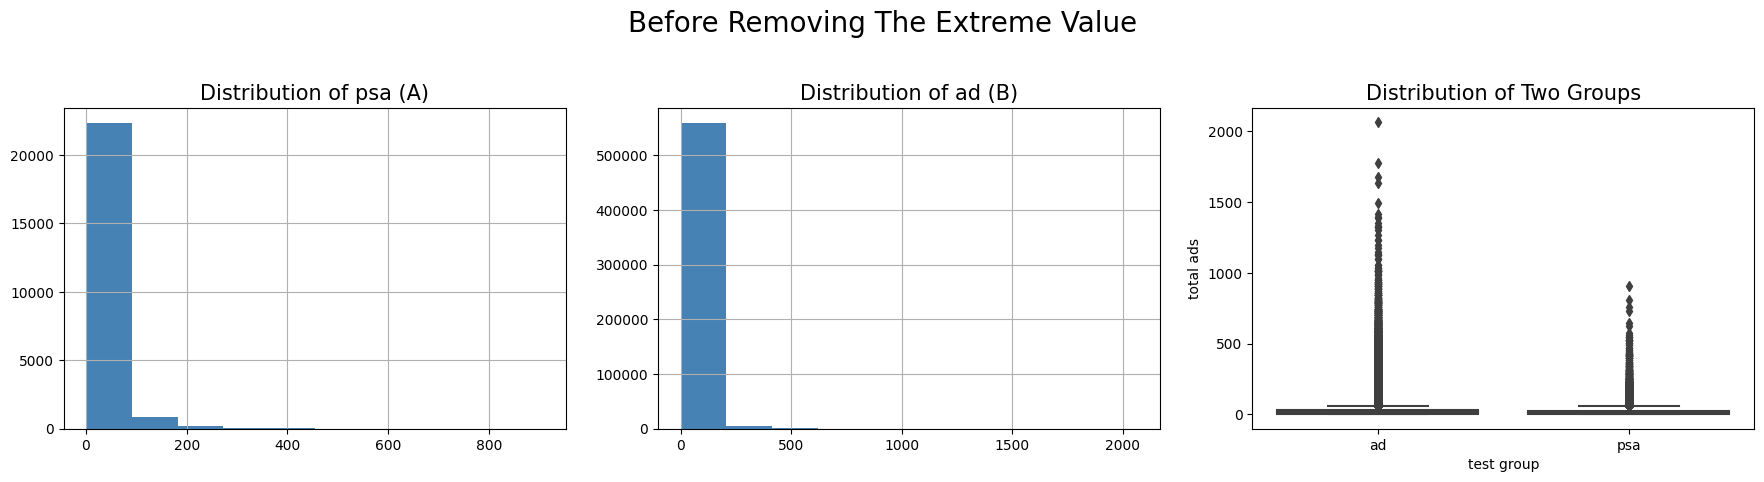

In [47]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
raw[(raw["test group"] == "psa")].hist("total ads", ax = axes[0], color = "steelblue")
raw[(raw["test group"] == "ad")].hist("total ads", ax = axes[1], color = "steelblue")
sns.boxplot(x = raw["test group"], y = raw["total ads"], ax = axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of psa (A)", fontsize = 15)
axes[1].set_title("Distribution of ad (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 2);

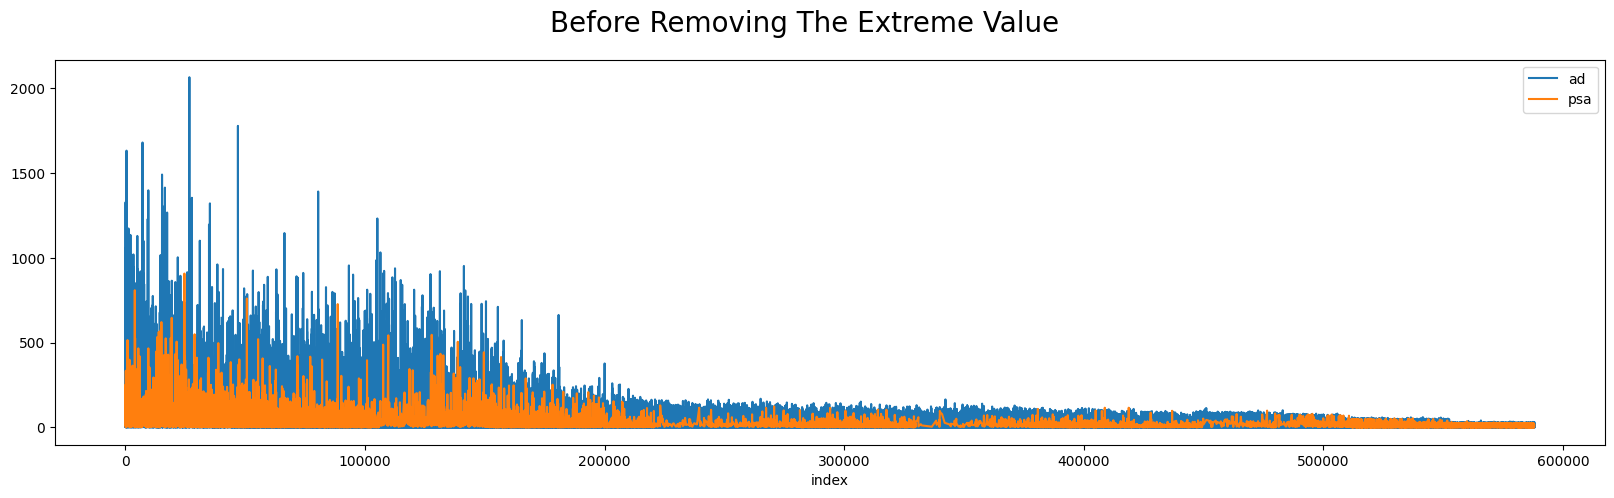

In [48]:
raw[raw["test group"] == "ad"].reset_index().set_index("index")["total ads"].plot(legend = True, label = "ad", figsize = (20,5))
raw[raw["test group"] == "psa"].reset_index().set_index("index")["total ads"].plot(legend = True, label = "psa")
plt.suptitle("Before Removing The Extreme Value", fontsize = 20);

# 03 Outliers
- Note: In original notebook and dataset, removing outliers affected data distribution significantly. But, in this dataset I can't see the need of this step. It could be passed depends on the distribution of dataset.

In [49]:
raw = raw[raw["total ads"] < raw["total ads"].max()]

# Summary Stats: total ads
raw.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["total ads"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
total ads,588100.0000,24.8174,43.6342,1.0000,1.0000,1.0000,2.0000,3.0000,13.0000,33.0000,57.0000,88.0000,202.0000,1778.0000


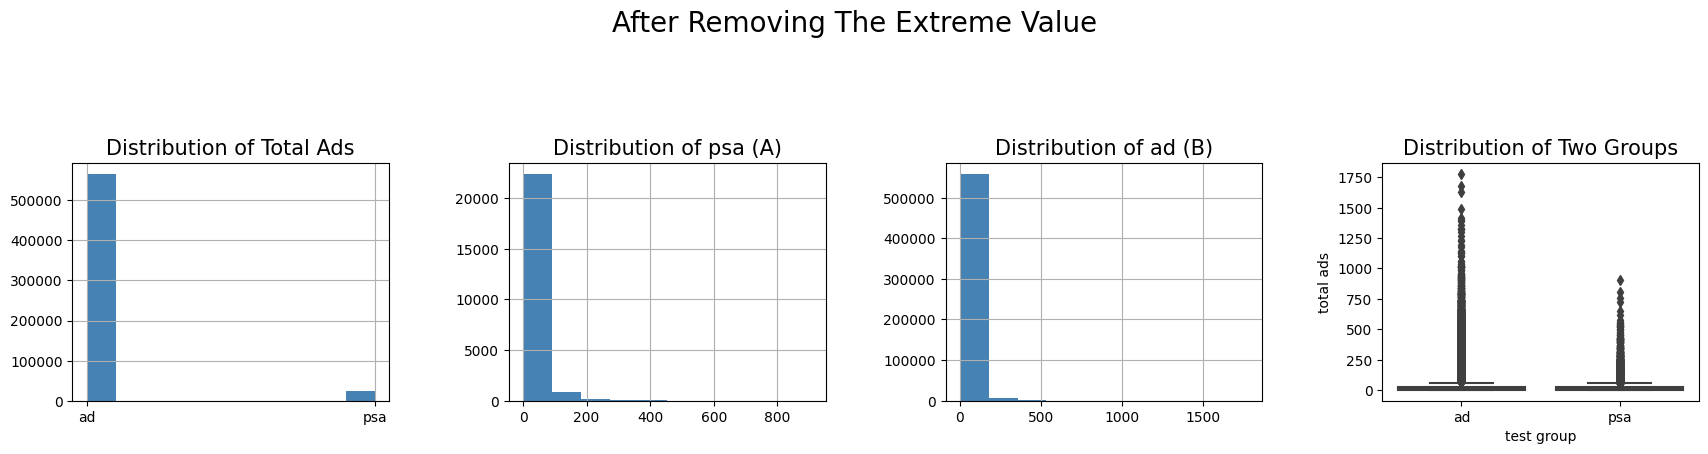

In [50]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
raw["test group"].hist(ax = axes[0], color = "steelblue")
raw[(raw["test group"] == "psa")].hist("total ads", ax = axes[1], color = "steelblue")
raw[(raw["test group"] == "ad")].hist("total ads", ax = axes[2], color = "steelblue")
sns.boxplot(x = raw["test group"], y = raw["total ads"], ax = axes[3])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Ads", fontsize = 15)
axes[1].set_title("Distribution of psa (A)", fontsize = 15)
axes[2].set_title("Distribution of ad (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

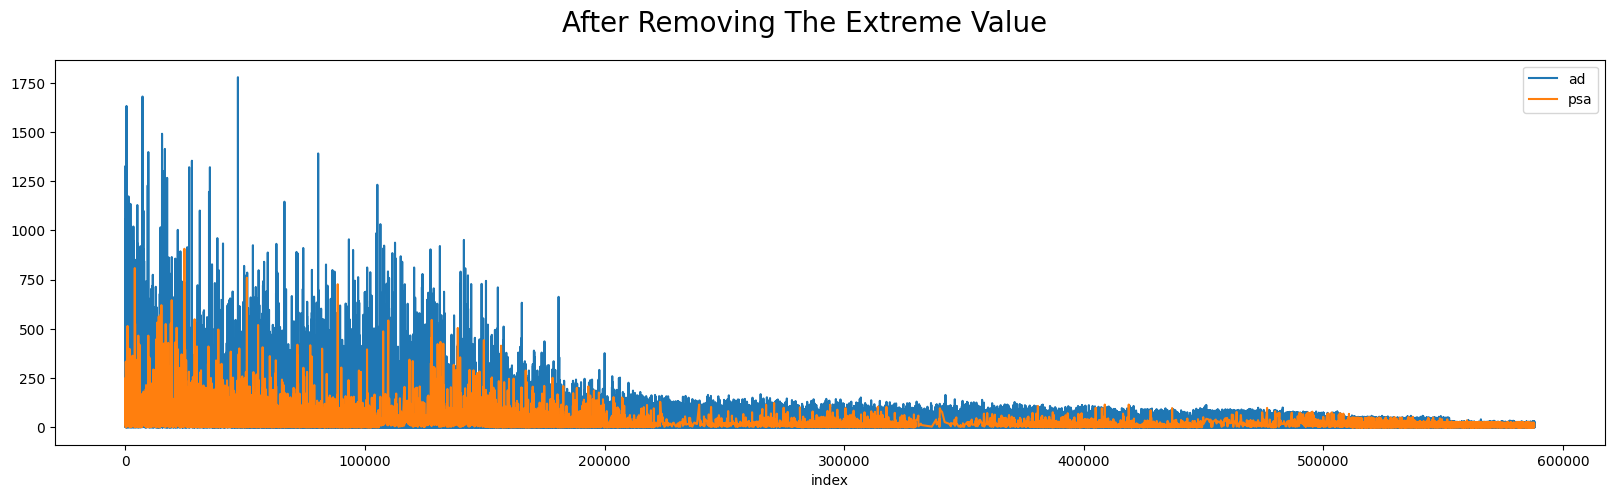

In [51]:
raw[raw["test group"] == "ad"].reset_index().set_index("index")["total ads"].plot(legend = True, label = "ad", figsize = (20,5))
raw[raw["test group"] == "psa"].reset_index().set_index("index")["total ads"].plot(legend = True, label = "psa")
plt.suptitle("After Removing The Extreme Value", fontsize = 20);

# 03-1 Interesting Persona
- What's the most ads day of two groups? Are they alike or not?
- What's the most ads hour of two groups? Are they alike or not?
- What kinds of reasons make the difference?

In [52]:
# A/B Groups & most ads day Summary Stats
stats_most_ad_day = raw.groupby(["test group","most ads day"]).size().unstack(fill_value=0)
col_arrange = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
stats_most_ad_day = stats_most_ad_day[col_arrange]
stats_most_ad_day

most ads day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
test group,,,,,,,
ad,83571,74572,77418,79077,88804,78802,82332
psa,3502,2907,3490,3905,3803,2858,3059


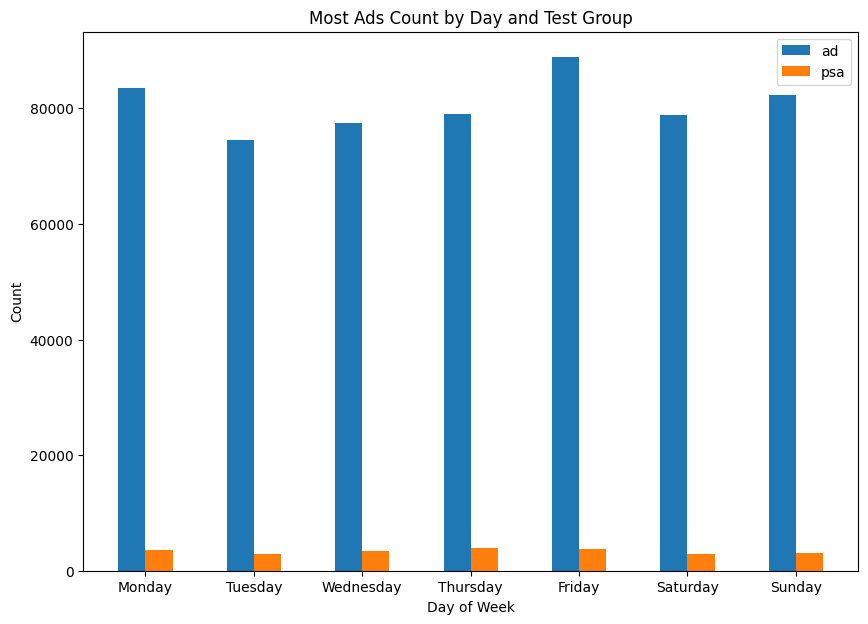

In [53]:
# 資料
test_groups = stats_most_ad_day.index
days = stats_most_ad_day.columns
counts_ad = stats_most_ad_day.loc["ad"]
counts_psa = stats_most_ad_day.loc["psa"]

# 繪製長條圖
x = range(len(days))
width = 0.25

fig, ax = plt.subplots(figsize=(10,7))
bars_ad = ax.bar(x, counts_ad, width, label='ad')
bars_psa = ax.bar([i + width for i in x], counts_psa, width, label='psa')

# 添加軸標籤和標題
ax.set_xlabel('Day of Week')
ax.set_ylabel('Count')
ax.set_title('Most Ads Count by Day and Test Group')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(days)
ax.legend(loc='upper right')

# 顯示圖表
plt.show()

**Personal guess**:

In [54]:
# A/B Groups & most ads day Summary Stats
stats_most_ad_hour = raw.groupby(["test group","most ads hour"]).size().unstack(fill_value=0)
stats_most_ad_hour

most ads hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
test group,,,,,,,,,,,,,,,,,,,,,,,,
ad,5309,4615,5152,2590,694,742,1985,6168,16968,29802,37453,44149,45238,45485,43779,42855,35963,33605,31052,29169,27846,28895,25515,19547
psa,227,187,181,89,28,23,83,237,659,1202,1485,2061,2060,2170,1869,1828,1604,1383,1271,1183,1077,1081,917,619


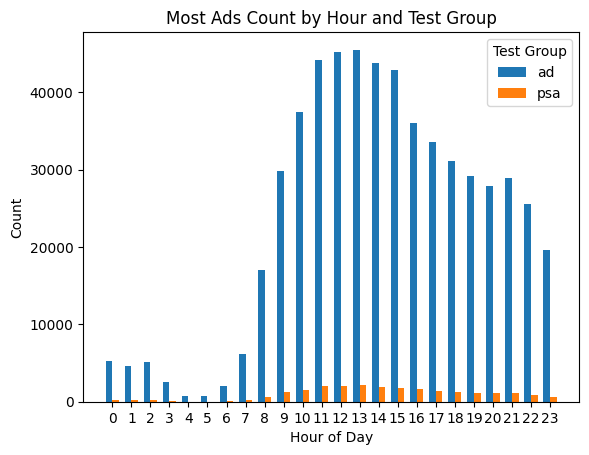

In [55]:
# 提取測試組別和時間資料
test_groups = stats_most_ad_hour.index
hours = stats_most_ad_hour.columns

# 資料
ad_counts = stats_most_ad_hour.loc["ad"]
psa_counts = stats_most_ad_hour.loc["psa"]

# 設置長條寬度
bar_width = 0.35

# 設置 x 軸位置
x = np.arange(len(hours))

# 繪製長條圖
plt.bar(x - bar_width/2, ad_counts, width=bar_width, label='ad')
plt.bar(x + bar_width/2, psa_counts, width=bar_width, label='psa')

# 設置 x 軸刻度標籤
plt.xticks(ticks=x, labels=hours)

# 添加圖表標題和軸標籤
plt.title('Most Ads Count by Hour and Test Group')
plt.xlabel('Hour of Day')
plt.ylabel('Count')

# 添加圖例
plt.legend(title='Test Group')

# 顯示圖表
plt.show()

# 04 Some details

The graph shows that
- 01: The number of users drops drastically as they view more ads over time.
- 02: The number of users halves when the number of ads increases up to 4.

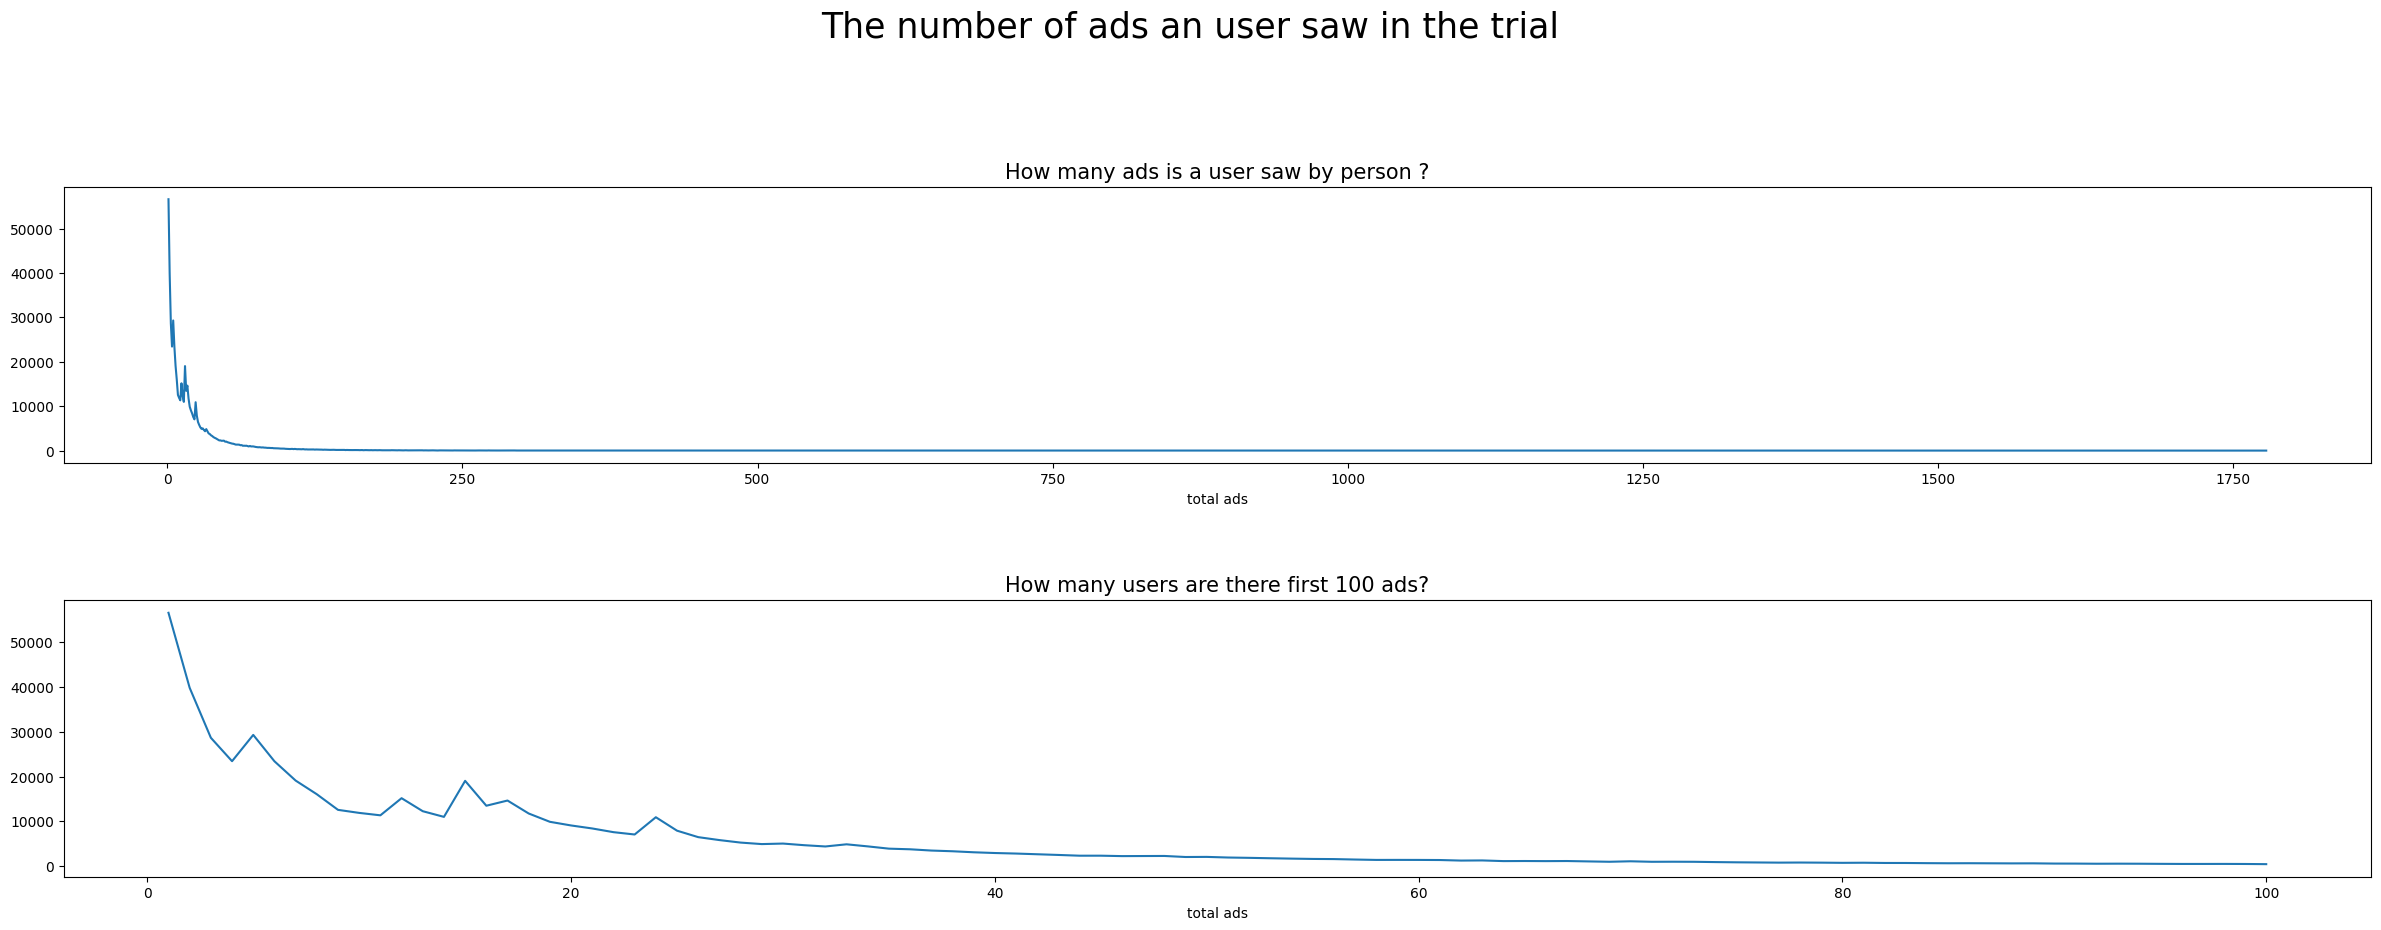

In [56]:
fig, axes = plt.subplots(2, 1, figsize = (25,10))
raw.groupby("total ads")['user id'].count().plot(ax = axes[0])
raw.groupby("total ads")['user id'].count()[:100].plot(ax = axes[1])
plt.suptitle("The number of ads an user saw in the trial", fontsize = 25)
axes[0].set_title("How many ads is a user saw by person ?", fontsize = 15)
axes[1].set_title("How many users are there first 100 ads?", fontsize = 15)
plt.tight_layout(pad=5);

# Save the figure
plt.savefig('my_plot.png')

In [57]:
raw.groupby("total ads")['user id'].count().reset_index().head(20)

,total ads,user id
0,1,56606
1,2,39827
2,3,28661
3,4,23426
4,5,29303
5,6,23409
6,7,19095
7,8,16037
8,9,12546
9,10,11865


In [58]:
# How many users see psa & ads?
raw.groupby("total ads")['user id'].count().loc[[1, 4, 9]]

total ads
1    56606
4    23426
9    12546
Name: user id, dtype: int64

**Test group variables gives us user converted rate details.**

<li><code>ad</code> - the person saw the advertisement.</li>
<li><code>psa</code> - the person saw the public service announcement</li>

Also users tend not to watch the ads! There are many users who quit the website.

In [59]:
raw.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [60]:
# Converted Problem
ad_df = raw[raw['test group'] == 'ad']
psa_df = raw[raw['test group'] == 'psa']

pd.DataFrame({"PSA_COUNT":psa_df['converted'].value_counts(),
              "AD_COUNT": ad_df["converted"].value_counts(),
              "PSA_RATIO": psa_df['converted'].value_counts() / len(psa_df),
              "AD_RATIO": ad_df["converted"].value_counts() / len(ad_df)})

,PSA_COUNT,AD_COUNT,PSA_RATIO,AD_RATIO
converted,,,,
False,23104,550153,0.9821,0.9745
True,420,14423,0.0179,0.0255


Ad has a higher converted ratio(2.55%) than psa(1.79%).

In [61]:
raw.groupby(["test group", "converted"])['total ads'].agg(["count", "median", "mean", "std", "max"])

count  median    mean     std   max
test group converted                                      
ad         False      550153 13.0000 23.2707 40.7685  1632
           True        14423 64.0000 83.9056 87.5042  1778
psa        False       23104 11.0000 23.6974 40.9065   907
           True          420 55.0000 83.2762 85.8672   563

**Findings** 

If we seperate users into 2 groups, one is converted and the other is not converted, then we can see:

- 01: People who were converted tend to watch more ads before buying, no matter the testing way is ad or psa.

In [66]:
raw['test group'].value_counts()

test group
ad     564576
psa     23524
Name: count, dtype: int64

# 05 A/B Testing

In [67]:
# Define A/B groups
raw["version"] = np.where(raw['test group'] == "psa", "A", "B")
raw.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour,version
0,0,1069124,ad,False,130,Monday,20,B
1,1,1119715,ad,False,93,Tuesday,22,B
2,2,1144181,ad,False,21,Tuesday,18,B
3,3,1435133,ad,False,355,Tuesday,10,B
4,4,1015700,ad,False,276,Friday,14,B


In [64]:
groupA = raw[raw["test group"] == "A"]["converted"]
groupB = raw[raw["test group"] == "B"]["converted"]
len(groupB)

0

In [70]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(dataframe=raw, group = "version", target = "converted")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.0000,A/B groups are not similar!


In [72]:
raw.groupby("version")['total ads'].mean(), raw.groupby("version")['converted'].mean()

(version
 A   24.7611
 B   24.8198
 Name: total ads, dtype: float64,
 version
 A   0.0179
 B   0.0255
 Name: converted, dtype: float64)

## Conclusion
- from analyst's perspective, this A/B test rejects H0 hypothesis, so we know this A/B test's result is reliable.
- Mean value of totals ads slightly increase while applying ads, but the converted ratio increase much!(from 1.79% to 2.55 %) Which means the ads attracted more users to buy the product.